In [1]:
import scanpy as sc
import pandas as pd
import numpy as np

In [2]:
import scipy.sparse as sp

## SCP1064 data download and processing

https://github.com/Genentech/dcdfg/tree/main/perturb-cite-seq

In [3]:
data = sc.read_csv("dcdfg_perturbseq/SCP1064/other/RNA_expression.csv.gz").transpose()

In [4]:
data_sp = sp.csr_matrix(data.X)

In [5]:
# get covariates 
covariates =  pd.read_csv("dcdfg_perturbseq/SCP1064/metadata/RNA_metadata.csv", index_col=0).iloc[1:, ]
data.obs = covariates

/net/dali/home/mscbio/meh251/.conda/envs/pytorch/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3460: DtypeWarning: Columns (3,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
# correct dtypes
data.obs["MOI"] = data.obs["MOI"].astype(np.int32)
data.obs["UMI_count"] = data.obs["UMI_count"].astype(np.double)

In [7]:
# de-normalize and round up
norm_factor =  data.obs["UMI_count"].values / 1.0e6
Z = sp.diags(norm_factor).dot(np.expm1(data_sp))
print(np.greater_equal(np.abs(Z.data - np.rint(Z.data)), 0.01).any())
Z.data = np.rint(Z.data)
data.X = Z

False


In [8]:
# read guide info
guide_info = pd.read_csv("dcdfg_perturbseq/SCP1064/documentation/all_sgRNA_assignments.txt", index_col=0)
guide_info = guide_info.replace(np.nan,'',regex=True)
data.obs["sgRNAs"] = guide_info["sgRNAs"].astype(str)

In [9]:
data.write_h5ad("dcdfg_perturbseq/SCP1064/other/adata.h5ad")

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.sparse as sp
from tqdm import tqdm
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.stats import nbinom, norm
from scipy.interpolate import make_interp_spline

In [30]:
import warnings
warnings.filterwarnings("ignore")

In [10]:
%%time 
adata = sc.read_h5ad("dcdfg_perturbseq/SCP1064/other/adata.h5ad")
adata.X.data

CPU times: user 1.13 s, sys: 11.2 s, total: 12.3 s
Wall time: 33.6 s


array([2., 1., 1., ..., 2., 1., 1.])

In [16]:
# export raw gene expression for FR_Perturb (cocult)
adata_filtered = sc.read_h5ad('dcdfg_perturbseq/SCP1064/ready/cocult/adata.h5ad')
adata_cocult = adata[adata_filtered.obs_names,adata_filtered.var_names]
adata_cocult.copy().write_h5ad("dcdfg_perturbseq/SCP1064/ready/cocult/raw_adata.h5ad")

In [3]:
sc.pp.filter_cells(adata, min_genes=0)
sc.pp.filter_genes(adata, min_cells=0)

In [4]:
(adata.obs["n_genes"] < 500).sum(), (adata.var["n_cells"] < 500).sum()

(304, 8376)

In [5]:
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_genes(adata, min_cells=500)

In [6]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e5)
sc.pp.log1p(adata)

In [7]:
# make sure we can match sgRNAs back to the genes
adata.obs

,library_preparation_protocol,condition,MOI,sgRNA,UMI_count,sgRNAs,n_genes
NAME,,,,,,,
CELL_1,10X 3' v3 sequencing,Control,1,HLA-B_2,10832.0,HLA-B_2,3520
CELL_2,10X 3' v3 sequencing,Control,2,NaN,10731.0,"NGFR_3,SERPINF1_3",3531
CELL_3,10X 3' v3 sequencing,Control,1,HLA-B_2,28821.0,HLA-B_2,5541
CELL_4,10X 3' v3 sequencing,Control,2,NaN,15322.0,"NMRK1_3,S100A6_3",4086
CELL_5,10X 3' v3 sequencing,Control,0,NaN,10314.0,,3178
...,...,...,...,...,...,...,...
CELL_218327,10X 3' v3 sequencing,Co-culture,4,NaN,12722.0,"CTSO_3,PIK3IP1_3,VDAC2_2,WNT7A_1",3686
CELL_218328,10X 3' v3 sequencing,Co-culture,2,NaN,11643.0,"JAK2_3,SLC7A5P1_3",3462
CELL_218329,10X 3' v3 sequencing,Co-culture,3,NaN,12497.0,"S100A6_2,SAT1_2,ONE_NON-GENE_SITE_177",3768


In [8]:
# check gene sets and ensure matching with measurements
err = 0
ind = []
obs_genes = {}
unfound_genes = {}
targets = []
for index, row in tqdm(adata.obs.iterrows(), total=adata.n_obs):
    current_target = []
    if row["sgRNAs"] != "":
        # get all guides in cells
        sg = row["sgRNAs"].split(",")
        # get gene name by stripping guide specific info
        sg_genes = [guide.rsplit("_", maxsplit=1)[0] for guide in sg]
        for gene in sg_genes:
            if gene in adata.var.index:
                # gene is found
                current_target += [gene]
                if gene not in obs_genes:
                    obs_genes[gene] = 1
                else:
                    obs_genes[gene] += 1
            else:
                if gene not in unfound_genes:
                    unfound_genes[gene] = 1
                else:
                    unfound_genes[gene] += 1
    # end gene list
    targets += [",".join(current_target)]

100%|██████████| 218027/218027 [00:07<00:00, 30568.19it/s]


In [26]:
len(targets)

218027

In [9]:
regimes = np.unique(targets, return_inverse=True)[1]

In [10]:
adata.obs["targets"] = targets
adata.obs["regimes"] = regimes

In [12]:
%%time
sc.pp.highly_variable_genes(adata, layer="counts", flavor='seurat_v3', n_top_genes=3000 , span=0.2)

CPU times: user 30.8 s, sys: 14min 54s, total: 15min 25s
Wall time: 15min 28s


In [14]:
adata.obs.to_csv('meta.csv')

In [13]:
adata.var

,n_cells,highly_variable,highly_variable_rank,means,variances,variances_norm
A1BG,34703,True,1689.0,0.189256,0.232778,1.069112
A1BG-AS1,12461,False,NaN,0.060226,0.063213,0.964280
A4GALT,1537,False,NaN,0.007233,0.007566,0.985149
AAAS,39657,False,NaN,0.213538,0.241693,0.970792
AACS,19249,False,NaN,0.094887,0.099974,0.948419
...,...,...,...,...,...,...
ZXDB,2581,False,NaN,0.011994,0.012162,0.957151
ZXDC,14586,False,NaN,0.070569,0.073387,0.947735
ZYG11B,26023,False,NaN,0.132493,0.144036,0.972143
ZYX,153542,False,NaN,1.634701,3.017341,0.954339


In [16]:
presence = pd.Series(data=np.zeros_like(adata.var["means"]), index=adata.var.index)
for gene in list(obs_genes.keys()):
    presence[gene] += 1
adata.var["targeted"] = presence

In [24]:
adata.var.to_csv('genes.csv')

In [17]:
# filter genes (1000)
to_keep = np.logical_or(adata.var["highly_variable_rank"] < 1500, adata.var["targeted"])
adata_gf = adata[:, to_keep].copy()

In [23]:
adata_gf.var.to_csv('filterd_genes.csv')

In [19]:
# filter conditions
adata_gf[adata_gf.obs.condition == "Control"].copy().write_h5ad("SCP1064/ready/control/gene_filtered_adata.h5ad")
adata_gf[adata_gf.obs.condition == "Co-culture"].copy().write_h5ad("SCP1064/ready/cocult/gene_filtered_adata.h5ad")
adata_gf[adata_gf.obs.condition == "IFNγ"].copy().write_h5ad("SCP1064/ready/ifn/gene_filtered_adata.h5ad")

In [20]:
adata_small = adata_gf[np.random.choice(np.arange(adata.n_obs), size=10000, replace=False)].copy()
adata_small.write_h5ad("SCP1064/other/small_adata.h5ad")

In [22]:
adata_gf.var

,n_cells,highly_variable,highly_variable_rank,means,variances,variances_norm,targeted
ABCG2,43098,True,713.0,0.270783,0.412499,1.280399,0.0
ABHD14B,63330,True,1215.0,0.412132,0.593385,1.130482,0.0
ABHD17C,34522,True,638.0,0.206818,0.319366,1.328197,0.0
ABL2,74230,True,1002.0,0.493535,0.760715,1.170876,0.0
AC003092.1,36602,True,324.0,0.237562,0.475413,1.700979,0.0
...,...,...,...,...,...,...,...
ZNF665,2986,True,1287.0,0.014136,0.016789,1.118916,0.0
ZNF676,4255,True,1482.0,0.021282,0.024746,1.091299,0.0
ZNF723,2780,True,1071.0,0.014072,0.017268,1.156160,0.0
ZNF781,4637,True,1155.0,0.023639,0.028695,1.138998,0.0


## Explore dropout features in Co-culture data

In [ ]:
#cocult_raw = sc.read_h5ad('dcdfg_perturbseq/SCP1064/ready/cocult/raw_adata.h5ad') 
#cocult_raw[cocult_raw.obs.MOI == 0].copy().write_h5ad("dcdfg_perturbseq/SCP1064/ready/cocult/raw_unperturbed_adata.h5ad")

In [2]:
cocult_raw = sc.read_h5ad('dcdfg_perturbseq/SCP1064/ready/cocult/raw_unperturbed_adata.h5ad') 

In [18]:
cocult_raw

AnnData object with n_obs × n_vars = 7556 × 15335
    obs: 'library_preparation_protocol', 'condition', 'MOI', 'sgRNA', 'UMI_count', 'sgRNAs'

In [19]:
non_zero_percentages = np.sum(cocult_raw.X != 0, axis=0) / cocult_raw.X.shape[0] * 100
zero_percentages = 100 - non_zero_percentages

In [20]:
non_zero_percentages.shape

(1, 15335)

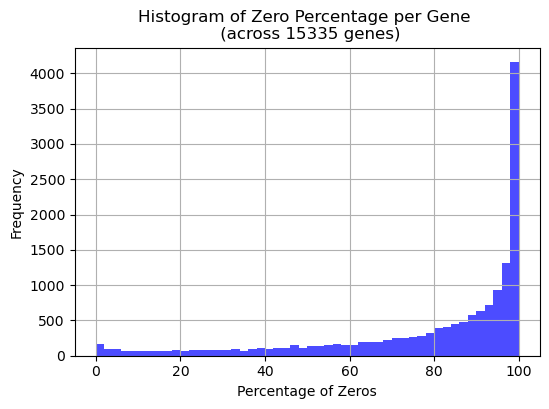

In [21]:
zero_percentages = np.array(zero_percentages).flatten()

plt.figure(figsize=(6, 4))
plt.hist(zero_percentages, bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Zero Percentage per Gene \n (across 15335 genes)')
plt.xlabel('Percentage of Zeros')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Explore gene expression distribution in Co-culture data

In [3]:
# load log1p transformed data
cocult_filtered = sc.read_h5ad('dcdfg_perturbseq/SCP1064/ready/cocult/gene_filtered_adata.h5ad') 

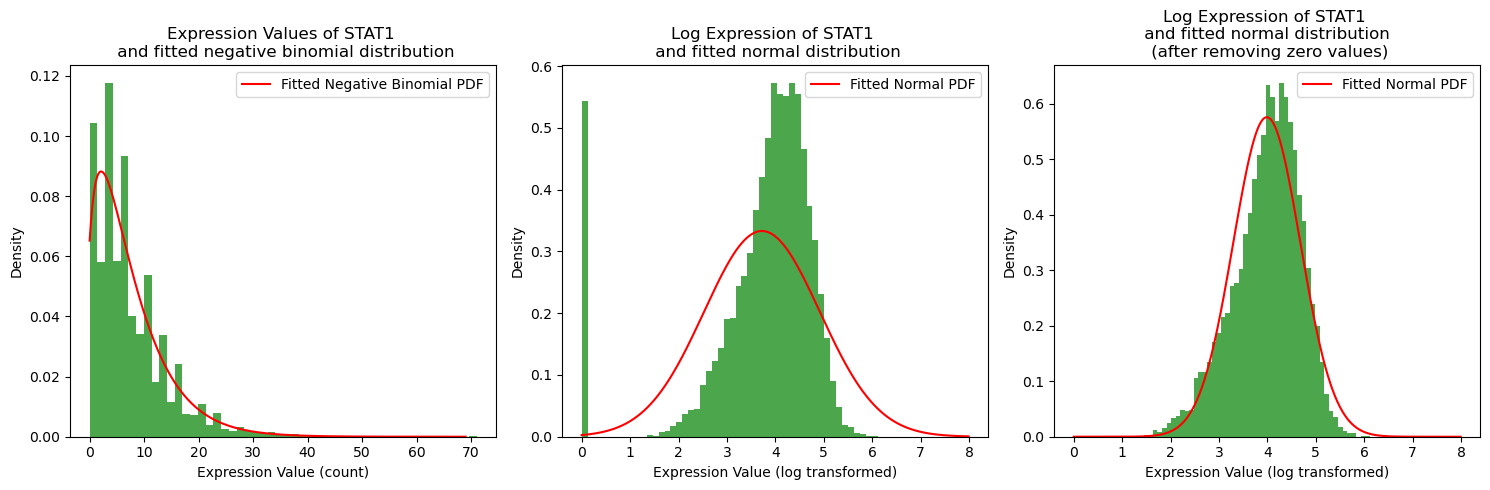

In [33]:
# Data and parameter for the zeroth plot (raw data)
gene_of_interest = 'STAT1'
gene_index = cocult_raw.var_names.get_loc(gene_of_interest)
gene_expression0 = cocult_raw.X[:, gene_index].toarray().flatten() if hasattr(cocult_raw.X, 'toarray') else cocult_raw.X[:, gene_index]


# Data and parameters for the first plot (log data)
mu1 = 3.722293415
sd1 = 1.197740901
gene_index = cocult_filtered.var_names.get_loc(gene_of_interest)
gene_expression1 = cocult_filtered.X[cocult_filtered.obs.MOI == 0, gene_index].toarray().flatten() if hasattr(cocult_filtered.X, 'toarray') else cocult_filtered.X[:, gene_index]

# Data and parameters for the second plot (log data)
mu2 = 3.987191528
sd2 = 0.693163974
gene_expression2 = gene_expression[gene_expression!=0]

plt.figure(figsize=(15, 5))

# Plot 0
plt.subplot(1, 3, 1)
mu = 7.491518
dispersion = 1.546387
p = dispersion / (dispersion + mu)
plt.hist(gene_expression0, bins=50, color='green', alpha=0.7, density=True)  # density=True normalizes the histogram
x = np.arange(0, 70, 1) 
pdf_vals = nbinom.pmf(x, dispersion, p)
x_smooth = np.linspace(x.min(), x.max(), 300)
y_smooth = make_interp_spline(x, pdf_vals)(x_smooth)
plt.plot(x_smooth, y_smooth, 'r-', label='Fitted Negative Binomial PDF')
plt.xlabel('Expression Value (count)')
plt.ylabel('Density')
plt.title(f'Expression Values of {gene_of_interest} \n and fitted negative binomial distribution')
plt.legend()


# Plot 1
plt.subplot(1, 3, 2)  # First subplot in a 1x2 grid
plt.hist(gene_expression1, bins=50, color='green', alpha=0.7, density=True)
x = np.arange(0, 8, 0.01)
pdf_vals1 = norm.pdf(x, mu1, sd1)
plt.plot(x, pdf_vals1, 'r-', label='Fitted Normal PDF')
plt.xlabel('Expression Value (log transformed)')
plt.ylabel('Density')
plt.title(f'Log Expression of {gene_of_interest} \n and fitted normal distribution')
plt.legend()

# Plot 2
plt.subplot(1, 3, 3)  # Second subplot in a 1x2 grid
plt.hist(gene_expression2, bins=50, color='green', alpha=0.7, density=True)
pdf_vals2 = norm.pdf(x, mu2, sd2)
plt.plot(x, pdf_vals2, 'r-', label='Fitted Normal PDF')
plt.xlabel('Expression Value (log transformed)')
plt.ylabel('Density')
plt.title(f'Log Expression of {gene_of_interest} \n and fitted normal distribution \n (after removing zero values)')
plt.legend()

plt.tight_layout()
plt.show()


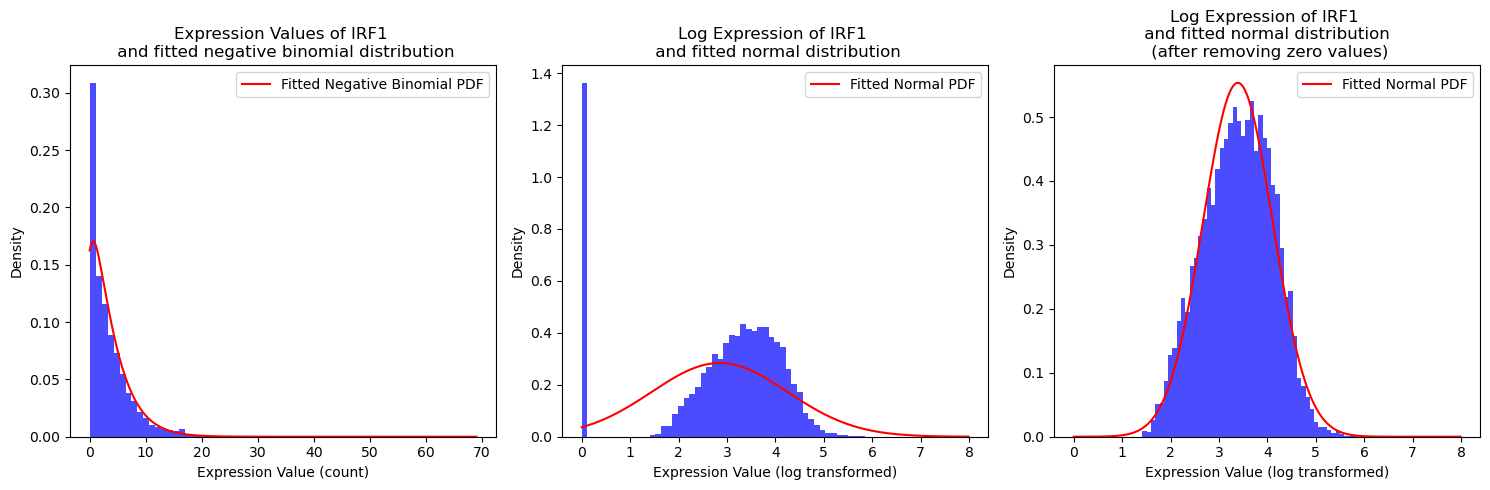

In [5]:
# Data and parameter for the zeroth plot (raw data)
gene_of_interest = 'IRF1'
gene_index = cocult_raw.var_names.get_loc(gene_of_interest)
gene_expression0 = cocult_raw.X[:, gene_index].toarray().flatten() if hasattr(cocult_raw.X, 'toarray') else cocult_raw.X[:, gene_index]


# Data and parameters for the first plot (log data)
mu1 = 2.84831820
sd1 = 1.40570746
gene_index = cocult_filtered.var_names.get_loc(gene_of_interest)
gene_expression1 = cocult_filtered.X[cocult_filtered.obs.MOI == 0, gene_index].toarray().flatten() if hasattr(cocult_filtered.X, 'toarray') else cocult_filtered.X[:, gene_index]

# Data and parameters for the second plot (log data)
mu2 = 3.388740716
sd2 =  0.720817872
gene_expression2 = gene_expression1[gene_expression1!=0]

plt.figure(figsize=(15, 5))

# Plot 0
plt.subplot(1, 3, 1)
mu = 3.629281
dispersion = 1.449556
p = dispersion / (dispersion + mu)
plt.hist(gene_expression0, bins=30, color='blue', alpha=0.7, density=True)  # density=True normalizes the histogram
x = np.arange(0, 70, 1) 
pdf_vals = nbinom.pmf(x, dispersion, p)
x_smooth = np.linspace(x.min(), x.max(), 300)
y_smooth = make_interp_spline(x, pdf_vals)(x_smooth)
plt.plot(x_smooth, y_smooth, 'r-', label='Fitted Negative Binomial PDF')
plt.xlabel('Expression Value (count)')
plt.ylabel('Density')
plt.title(f'Expression Values of {gene_of_interest} \n and fitted negative binomial distribution')
plt.legend()


# Plot 1
plt.subplot(1, 3, 2)  # First subplot in a 1x2 grid
plt.hist(gene_expression1, bins=50, color='blue', alpha=0.7, density=True)
x = np.arange(0, 8, 0.01)
pdf_vals1 = norm.pdf(x, mu1, sd1)
plt.plot(x, pdf_vals1, 'r-', label='Fitted Normal PDF')
plt.xlabel('Expression Value (log transformed)')
plt.ylabel('Density')
plt.title(f'Log Expression of {gene_of_interest} \n and fitted normal distribution')
plt.legend()

# Plot 2
plt.subplot(1, 3, 3)  # Second subplot in a 1x2 grid
plt.hist(gene_expression2, bins=50, color='blue', alpha=0.7, density=True)
pdf_vals2 = norm.pdf(x, mu2, sd2)
plt.plot(x, pdf_vals2, 'r-', label='Fitted Normal PDF')
plt.xlabel('Expression Value (log transformed)')
plt.ylabel('Density')
plt.title(f'Log Expression of {gene_of_interest} \n and fitted normal distribution \n (after removing zero values)')
plt.legend()

plt.tight_layout()
plt.show()
